In [150]:
# install the dependencies needed for this project
!pip install bs4 beautifulsoup4 requests numpy matplotlib prettytable

You should consider upgrading via the '/Users/girishpandit/.python3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [151]:
from bs4 import BeautifulSoup
import csv
import requests

In [152]:
#build the url to scrape the data from the source using the request package
url = 'https://www.tesla.com/findus/list/superchargers/United+States'
response = requests.get(url, headers={'user-agent': 'chrome'})

In [153]:
# use BeautifulSoup package to extract data from html source
soup = BeautifulSoup(response.content, 'html.parser')
# Print out the contents of the html page
# print(soup)
states = soup.find_all('div', {'class': 'state'})
# Print out the contents of all states div
#print(states)

In [154]:
# we will use `SuperchargerData` to keep track of fields we are interested in
class SuperchargerData:
    def __init__(self, name, city, state, zipcode, streetAddress):
        self.name = name
        self.city = city
        self.state = state
        self.zipcode = zipcode
        self.streetAddress = streetAddress

In [155]:
# a function that maps html data into SuperchargerData objects
# data cleaning, only return SuperchargerData object if all the fields are available
def extract_data_from_vcard(vcard):
    name=vcard.find('a').text
#     name=Auburn Alabama Supercharger
    locality=vcard.find('span', {'class': 'locality'}).text
#     locality = Auburn, AL, 36830
    splits = locality.split(',')
#     splits = ['Auburn', ' AL, 36830']
#     print(f"splits: {splits}")
    if len(splits)<2:
        return None
    city=splits[0]
#     city= Auburn
    szplit=splits[1].split(' ')
#     szplit = ['', 'AL', '36830']
#     print(f"szsplit: {szplit}")
    if len(szplit)<3:
        return None
    state=szplit[1]
    zipcode=szplit[2]
#     state=AL
#     zipcode=36830
    streetAddress=vcard.find('span', {'class': 'street-address'}).text
#     streetAddress=1627 Opelika Road
    return SuperchargerData(name,city,state,zipcode,streetAddress)

In [156]:
# declare a list to contain the SuperchargerData objects extracted from vcards
already_open=[]

for state in states:
    for vcard in state.find_all('address', {'class': 'vcard'}):
        try: 
            if not '(coming soon)' in vcard.text:
                data=extract_data_from_vcard(vcard)
                if data is not None:
                    already_open.append(data)
        except:
            continue
#print(f'already_open: {already_open}')


##### Tier 1 analysis

In [157]:
# some Basic tier 1 analysis
print(f'list of open superchargers from raw html data: {len(already_open)}')
ca_filter=filter(lambda x:x.state == "CA",already_open)
a=list(map(lambda x:x.name,ca_filter))
print('\nlist of supercharger names in CA:')
print('\n'.join(map(str, a)))

list of open superchargers from raw html data: 879

list of supercharger names in CA:
Alameda, CA Supercharger
Anaheim, CA - East Katella Avenue Supercharger
Anaheim, CA - Santa Ana Canyon Road Supercharger
Antioch, CA Supercharger
Atascadero, CA Supercharger
Baker, CA Supercharger
Bakersfield Supercharger
Barstow Supercharger
Beaumont, CA Supercharger
Big Sur, CA - Ventana Supercharger
Buellton, CA Supercharger
Buena Park
Buena Park, CA - Beach Boulevard Supercharger
Burbank - North Third Street
Buttonwillow Supercharger
Cabazon Supercharger
Carlsbad, CA Supercharger
Cerritos, CA Supercharger
Chico, CA Supercharger
Chula Vista, CA Supercharger
Corning, CA Supercharger
Corona, CA Supercharger
Corte Madera, CA Supercharger
Crescent City Supercharger
Culver City Supercharger
Daly City, CA Supercharger
Downey, CA - Lakewood Boulevard Supercharger
Downey, CA - Stonewood Street Supercharger
Dublin-Amador Plaza
East Palo Alto, CA Supercharger
El Centro Supercharger
El Cerrito, CA Supercharge

In [158]:
import sqlite3
import json
import matplotlib.pyplot as plt

In [159]:
# we connect to sqlite3 db by creating a new sqlite db file
import time
db = sqlite3.connect(f"final_project_{time.time_ns()}.sqlite")
c=db.cursor()

In [160]:
#drop any previously created table
c.execute('''drop table if exists superchargers_html''')
#create a table
c.execute('''create table if not exists superchargers_html (name text primary key, streetAddress text, city text, zipcode integer, state text)''')

In [161]:
#iterate over SuperchargerData objects and insert it into db, if row already exists, catch it using IntegrityError
query = "insert into superchargers_html values (?,?,?,?,?)"
columns = ['name','streetAddress', 'city', 'zipcode', 'state']
for d in already_open:
    keys=(d.name, d.streetAddress, d.city, d.zipcode, d.state)
    if all(keys):
        try:
            c=db.cursor()
            c.execute(query, keys)
        except sqlite3.IntegrityError as err:
#             catching the sqlite3.IntegrityError for PrimaryKey violation
            print(f"{err}: Duplicate Entry found: {keys[0]}")
            continue


UNIQUE constraint failed: superchargers_html.name: Duplicate Entry found: Brunswick, GA Supercharger
UNIQUE constraint failed: superchargers_html.name: Duplicate Entry found: Hudsonville, MI Supercharger
UNIQUE constraint failed: superchargers_html.name: Duplicate Entry found: Greenville Supercharger
UNIQUE constraint failed: superchargers_html.name: Duplicate Entry found: Arlington, VA Supercharger
UNIQUE constraint failed: superchargers_html.name: Duplicate Entry found: Lexington Supercharger
UNIQUE constraint failed: superchargers_html.name: Duplicate Entry found: Aberdeen Supercharger


In [162]:
# run a basic select * to see if data was uploaded to db correctly
c.execute('select * from superchargers_html')
rows = c.fetchall()
for row in rows:
    print(row)

('Auburn Alabama Supercharger', '1627 Opelika Road', 'Auburn', 36830, 'AL')
('Birmingham, AL Supercharger', '2221 Richard Arrington Junior Blvd', 'Birmingham', '35203-1103', 'AL')
('Greenville Supercharger', '219 Interstate Drive', 'Greenville', 36037, 'AL')
('Mobile Supercharger', '3201 Airport Blvd', 'Mobile', 36606, 'AL')
('Oxford, AL Supercharger', '1105 Oxford Exchange Blvd', 'Oxford', '36203-0000', 'AL')
('Steele Supercharger', '905 Steele Station Road', 'Steele', 35987, 'AL')
('Buckeye, AZ Supercharger', '416 S Watson Rd', 'Buckeye', 85326, 'AZ')
('Casa Grande, AZ Supercharger', '2453 E. Florence Blvd.', 'Casa Grande', 85194, 'AZ')
('Cordes Lakes, AZ Supercharger', '14925 Cordes Lakes Rd', 'Mayer', 86333, 'AZ')
('Ehrenberg, AZ Supercharger', '11 Frontage Road North', 'Ehrenberg', 85334, 'AZ')
('Flagstaff, AZ Supercharger', '2650 South Beulah Blvd', 'Flagstaff', 86001, 'AZ')
('Gila Bend, AZ Supercharger', '826 W Pima St.', 'Gila Bend', 85337, 'AZ')
('Holbrook, AZ Supercharger', '

In [163]:
# helper function that executes the query we pass to this function and returns a results of db rows
def execute_query(query, db):
    c=db.cursor()
    c.execute(query)
    rows = c.fetchall()
#     print('Printing rows for...', query, '\n')
    res=[]
    for row in rows:
        res.append(row)
#     print(res)
    return res

###### tier 2 and tier 3 analysis/queries

In [164]:
# state with minimum superchargers

res=execute_query('''
select min(num_sc), state 
from (select count(*) as num_sc,state from superchargers_html group by state) as subquery
''',db)

print(res)


[(1, 'DC')]


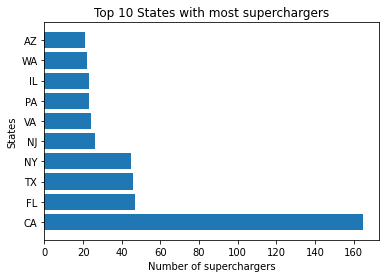

In [165]:
# top 10 states with most superchargers
res = execute_query('''
select count(*) as c, state from superchargers_html
group by state order by c desc limit 10''', db)
data=[]
for row in res:
    cf={}
    cf['count']=row[0]
    cf['state']=row[1]
    data.append(cf)
# https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barh.html
x=[i['state'] for i in data]
x_pos = [i for i, _ in enumerate(x)]
y = [i['count'] for i in data]
plt.barh(x_pos, y)
plt.ylabel("States")
plt.xlabel("Number of superchargers")
plt.title("Top 10 States with most superchargers")
plt.yticks(x_pos, x)
plt.show()

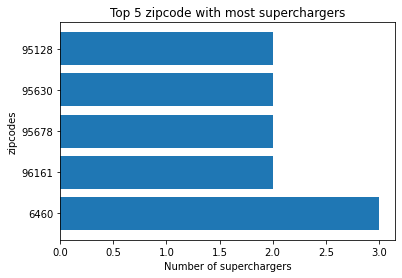

[('Milford - Boston Post Road Supercharger', '1201 Boston Post Road', 'Milford', 'CT', 6460), ('Milford, CT North Supercharger', 'Milford Travel Plaza', 'Milford', 'CT', 6460), ('Milford, CT South Supercharger', 'Travel Plaza', 'Milford', 'CT', 6460)]


In [166]:
# top 5 zipcode with most superchargers
res = execute_query('''
select count(*) as c, zipcode from superchargers_html
group by zipcode
order by c desc limit 5''', db)
data=[]
for row in res:
    cf={}
    cf['count']=row[0]
    cf['zipcode']=row[1]
    data.append(cf)
x=[i['zipcode'] for i in data]
x_pos = [i for i, _ in enumerate(x)]
facilities = [i['count'] for i in data]
plt.barh(x_pos, facilities)
plt.ylabel("zipcodes")
plt.xlabel("Number of superchargers")
plt.title("Top 5 zipcode with most superchargers")
plt.yticks(x_pos, x)
plt.show()
# print the supercharger location info with maximum superchargers by zipcode
res=execute_query('''
select name,streetAddress,city,state,zipcode from superchargers_html join 
(select count(*) as total, zipcode as max_z from superchargers_html 
group by zipcode order by total desc limit 1) as subqueryB
where zipcode=max_z
''',db)
print(res)

In [167]:
import pprint
pp = pprint.PrettyPrinter(indent=1)

In [168]:
#get the data from another source, filtering only for country=USA
# https://supercharge.info/about
base_url = 'https://supercharge.info/service/supercharge/allSites'
superchargers=[]
plain_json = requests.get(base_url).json()
for i in plain_json:
    if i['address']['country']=='USA':
        superchargers.append(i)
print('look at first object within json list:\n')
# lets look at total number of superchargers
print(f'\ntotal number of superchargers from json data: \
{len(superchargers)}')

# lets look at total number of superchargers that are currently 
# open using a filter function
print(f'\nnumber of open superchargers from json data: \
{len(list(filter(lambda x: "OPEN" in x["status"], superchargers)))}')
pp.pprint(superchargers[0])

look at first object within json list:


total number of superchargers from json data: 1032

number of open superchargers from json data: 888
{'address': {'city': 'San Juan Capistrano',
             'country': 'USA',
             'countryId': 100,
             'region': 'North America',
             'regionId': 100,
             'state': 'CA',
             'street': '31971 Camino Capistrano',
             'zip': '92675'},
 'battery': False,
 'counted': True,
 'dateOpened': '2014-05-06',
 'elevationMeters': 30,
 'gps': {'latitude': 33.498458, 'longitude': -117.6632},
 'id': 122,
 'locationId': 'sanjuancapistranosupercharger',
 'name': 'San Juan Capistrano, CA',
 'powerKilowatt': 0,
 'solarCanopy': False,
 'stallCount': 7,
 'status': 'OPEN',
 'statusDays': 0,
 'urlDiscuss': True}


In [169]:
# we will store this data into SuperchargerMetaData which extends SuperchargerData 
# in addition to date on which supercharger was opened and number of chargers
class SuperchargerMetaData(SuperchargerData):
    def __init__(self, name, city, state, zipcode, streetAddress, stallCount, dateOpened):
        super().__init__(name, city, state, zipcode, streetAddress)
        self.stallCount = stallCount
        self.dateOpened = dateOpened

# function that maps superchargers json data to SuperchargerMetaData object
# data cleansing, only look for OPEN status in supercharger data and extract the fields we are interested in
# if fields missing, return None
def open_superchargers_by_state(d):
    if 'OPEN' in d['status'] and 'address' in d.keys():
        name=d['name']
        if name is not None:
            nsplit=name.split(',')
            if len(nsplit)>1:
                name=nsplit[0]
        dateOpened=d['dateOpened']
        stallCount=d['stallCount']
        if 'zip' in d['address'].keys():
            zipcode=d['address']['zip']
        if 'city' in d['address'].keys():
            city=d['address']['city']
        if 'state' in d['address'].keys():
            state=d['address']['state']
        if 'street' in d['address'].keys():
            streetAddress=d['address']['street']
        return SuperchargerMetaData(name,city,state,zipcode,streetAddress,stallCount, dateOpened)
    return None

# using map function to map json to our SuperchargerMetaData object and then filter out any None from the list
supercharger_md = list(filter(lambda x: x is not None, map(open_superchargers_by_state, superchargers)))
# for d in supercharger_md:
#     print(d.name,d.dateOpened,d.stallCount,d.city,d.state,d.zipcode)

##### Tier 1 analysis

In [170]:
# lets look at total number of superchargers
print(f'\ntotal number of superchargers from json data: \
{len(superchargers)}')

# lets look at total number of superchargers that are currently 
# open using a filter function
print(f'\nnumber of open superchargers from json data: \
{len(list(filter(lambda x: "OPEN" in x["status"], superchargers)))}')


total number of superchargers from json data: 1032

number of open superchargers from json data: 888


In [171]:
# drop any previously created table
c.execute('''drop table if exists superchargers_json''')
# create a table
c.execute('''create table if not exists superchargers_json (name text primary key, dateOpened text, stallCount integer, zipcode integer, city text, state text)''')

In [172]:
# we iterate over SuperchargerMetaData objects and insert it into superchargers_json table, 
# catch any IntegrityError 
query='insert into superchargers_json values (?,?,?,?,?,?)'
for d in supercharger_md:
    try:
        keys=(d.name,d.dateOpened,d.stallCount,d.zipcode,d.city,d.state)
        if all(keys):
            try:
                c=db.cursor()
                c.execute(query, keys)
            except sqlite3.IntegrityError as err:
                print(f"{err}, {keys}")
                continue
    except KeyError:
        print(d)

UNIQUE constraint failed: superchargers_json.name, ('Greenwich', '2014-02-12', 4, '06830', 'Greenwich', 'CT')
UNIQUE constraint failed: superchargers_json.name, ('Milford', '2012-12-16', 2, '06460', 'Milford', 'CT')
UNIQUE constraint failed: superchargers_json.name, ('Burlington', '2013-07-13', 8, '98233', 'Burlington', 'WA')
UNIQUE constraint failed: superchargers_json.name, ('Auburn', '2014-12-23', 6, '36830', 'Auburn', 'AL')
UNIQUE constraint failed: superchargers_json.name, ('Las Vegas', '2015-09-14', 6, '87701', 'Las Vegas', 'NM')
UNIQUE constraint failed: superchargers_json.name, ('Hawthorne', '2016-05-03', 8, '89415', 'Hawthorne', 'NV')
UNIQUE constraint failed: superchargers_json.name, ('Lima', '2017-01-09', 8, '59739', 'Lima', 'MT')
UNIQUE constraint failed: superchargers_json.name, ('Lexington', '2015-12-16', 6, '24450', 'Lexington', 'VA')
UNIQUE constraint failed: superchargers_json.name, ('Springfield', '2016-11-16', 8, '65803', 'Springfield', 'MO')
UNIQUE constraint failed

In [173]:
# test if data was written to db correctly
c.execute('select * from superchargers_json')
rows = c.fetchall()
for row in rows:
    print(row)

('San Juan Capistrano', '2014-05-06', 7, 92675, 'San Juan Capistrano', 'CA')
('Glenwood Springs', '2013-09-17', 6, 81601, 'Glenwood Springs', 'CO')
('Grand Junction', '2014-01-10', 6, 81505, 'Grand Junction', 'CO')
('Hawthorne', '2012-11-19', 12, 90250, 'Hawthorne', 'CA')
('Buckeye', '2014-03-20', 8, 85326, 'Buckeye', 'AZ')
('Kingman', '2014-01-22', 6, 86401, 'Kingman', 'AZ')
('Buellton', '2013-07-13', 10, 93427, 'Buellton', 'CA')
('Corning', '2013-10-18', 6, 96021, 'Corning', 'CA')
('St. Augustine', '2014-01-03', 6, 32092, 'St. Augustine', 'FL')
('Port Orange', '2013-09-13', 6, 32128, 'Port Orange', 'FL')
('Folsom - Iron Point Road', '2013-11-19', 4, 95630, 'Folsom', 'CA')
('Rosemont', '2018-11-06', 10, 60018, 'Rosemont', 'IL')
('Atascadero', '2013-07-03', 8, 93422, 'Atascadero', 'CA')
('Port St. Lucie', '2013-07-24', 8, 34986, 'Port St. Lucie', 'FL')
('Barstow', '2012-11-19', 16, 92311, 'Barstow', 'CA')
('Tifton', '2014-07-10', 8, 31794, 'Tifton', 'GA')
('Yuma', '2014-02-04', 8, 8536

##### Tier 1 analysis on the data inserted inside the db

In [178]:
c.execute('''
select count(*) from superchargers_html
''')
rows = c.fetchall()
for row in rows:
    print(row)

(836,)


In [179]:
c.execute('''
select count(*) from superchargers_json''')
rows = c.fetchall()
for row in rows:
    print(row)

(844,)


##### Tier 2/3 analysis

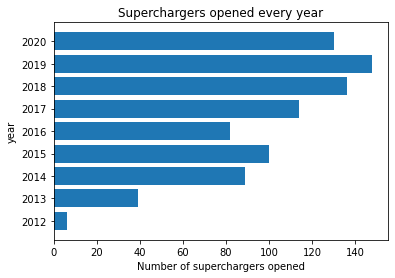

In [180]:
# use helper function to run a query that gives number of superchargers opened every year
res = execute_query('''
select count(*), strftime('%Y',dateOpened) as year 
from superchargers_json 
group by year''',db)
data=[]
for row in res:
    cf={}
    cf['count']=row[0]
    cf['year']=row[1]
    data.append(cf)
x=[i['year'] for i in data]
x_pos = [i for i, _ in enumerate(x)]
facilities = [i['count'] for i in data]
plt.barh(x_pos, facilities)
plt.ylabel("year")
plt.xlabel("Number of superchargers opened")
plt.title("Superchargers opened every year")
plt.yticks(x_pos, x)
plt.show()

In [181]:
# run a query to get states with max number of superchargers opened every year
res = execute_query('''
select year,max(c),state
from (select count(*) as c, strftime('%Y',dateOpened) as year, state
        from superchargers_json
        group by year, state) as subquery 
group by year''',db)
from prettytable import PrettyTable
t = PrettyTable(['Year', 'superchargers opened', 'state'])
for r in res:
    t.add_row(list(r))
print(t)

+------+----------------------+-------+
| Year | superchargers opened | state |
+------+----------------------+-------+
| 2012 |          5           |   CA  |
| 2013 |          7           |   CA  |
| 2014 |          9           |   AZ  |
| 2015 |          16          |   CA  |
| 2016 |          16          |   CA  |
| 2017 |          11          |   TX  |
| 2018 |          31          |   CA  |
| 2019 |          46          |   CA  |
| 2020 |          27          |   CA  |
+------+----------------------+-------+


In [182]:
#  get a break down of superchargers by state by year
res = execute_query('''
select year ,c,state
from (select count(*) as c, strftime('%Y',dateOpened) as year, state
        from superchargers_json
        group by year, state) as subquery 
group by year,state
order by year,state''',db)
from prettytable import PrettyTable
t = PrettyTable(['Year', 'superchargers opened', 'state'])
for r in res:
    t.add_row(list(r))
print(t)

+------+----------------------+-------+
| Year | superchargers opened | state |
+------+----------------------+-------+
| 2012 |          5           |   CA  |
| 2012 |          1           |   CT  |
| 2013 |          1           |   AZ  |
| 2013 |          7           |   CA  |
| 2013 |          2           |   CO  |
| 2013 |          1           |   CT  |
| 2013 |          3           |   FL  |
| 2013 |          2           |   IL  |
| 2013 |          2           |   IN  |
| 2013 |          1           |   MN  |
| 2013 |          2           |   NC  |
| 2013 |          1           |   NY  |
| 2013 |          3           |   OR  |
| 2013 |          1           |   SC  |
| 2013 |          3           |   SD  |
| 2013 |          5           |   TX  |
| 2013 |          1           |   VA  |
| 2013 |          2           |   WA  |
| 2013 |          1           |   WI  |
| 2013 |          1           |   WY  |
| 2014 |          1           |   AL  |
| 2014 |          9           |   AZ  |


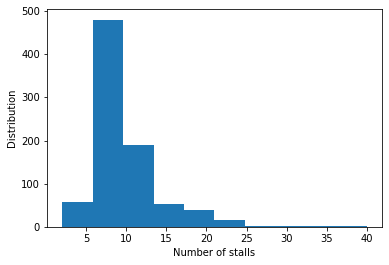

In [183]:
# ordered list of superchargers by most number of stalls available 
res=execute_query('''
select stallCount,name,state 
from superchargers_json 
group by name,state order by stallCount desc
''',db)
stalls=[x[0] for x in res]
# https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data
import matplotlib.pyplot as plt
import numpy as np
plt.hist(stalls, density=False)  # `density=False` would make counts
plt.ylabel('Distribution')
plt.xlabel('Number of stalls');
plt.show()

In [184]:
from prettytable import PrettyTable
t = PrettyTable(['Number of stalls', 'Supercharger Name', 'State'])
for r in res:
    t.add_row(list(r))

print(f'superchargers with most stalls in descending order: \n {t}')

superchargers with most stalls in descending order: 
 +------------------+-----------------------------------------+-------+
| Number of stalls |            Supercharger Name            | State |
+------------------+-----------------------------------------+-------+
|        40        |                  Baker                  |   CA  |
|        40        |                Daly City                |   CA  |
|        40        |              Kettleman City             |   CA  |
|        36        |                Quartzsite               |   AZ  |
|        35        |                 Aventura                |   FL  |
|        32        |              Santa Clarita              |   CA  |
|        30        |        Folsom - Palladio Parkway        |   CA  |
|        28        |               Paso Robles               |   CA  |
|        26        |                 Carlsbad                |   CA  |
|        26        |          San Jose - Santana Row         |   CA  |
|        24        |   

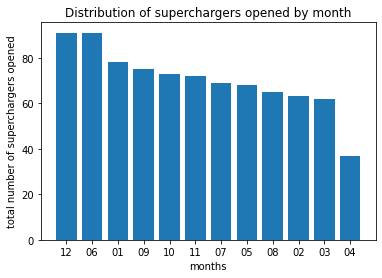

In [185]:
res = execute_query('''
select mo,sum(c) as total
from (select count(*) as c, strftime('%m',dateOpened) as mo
        from superchargers_json 
        group by mo) as subquery 
group by mo
order by total desc''',db)
data = [x[1] for x in res]
months = [x[0] for x in res]
plt.bar(months, data)
plt.xlabel('months')
plt.ylabel('total number of superchargers opened')
plt.title('Distribution of superchargers opened by month')
plt.show()

In [186]:
# Find the numbers of superchargers that have opened recently (start of the current week)

res=execute_query('''
select * from superchargers_json where date(dateOpened) >= date('2020-09-13')
''',db)

for r in res:
    print(r)

('Las Vegas - North Premium Outlets', '2020-09-15', 8, 89106, 'Las Vegas', 'NV')


In [187]:
# close the db connection now that we are done
db.close()